In [1]:
%load_ext autoreload
%autoreload 2

In [113]:
from pathlib import Path

IMAGE_DIR_PATH = str(Path().joinpath("image"))
IMAGE_NAME = "stickman_A4.jpg"
IMAGE_WIDTH_CLIPPING = 384
IMAGE_WIDTH_OUTPUT = 512
OUTPUT_DIR = "output"

image_path = str(Path(IMAGE_DIR_PATH, IMAGE_NAME))
print(image_path)

image/stickman_A4.jpg


# Load an Image

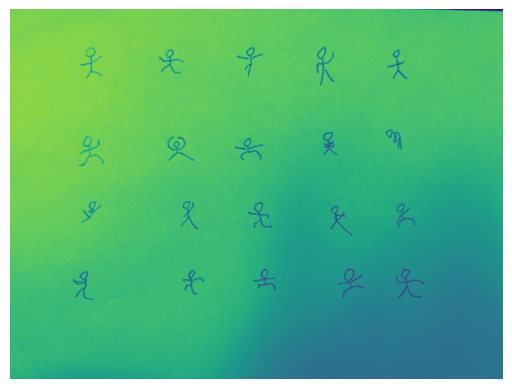

In [5]:
import cv2
from scripts.image import show_image_from_ndarray, rotate_anticlockwise_90

image_gray = rotate_anticlockwise_90(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE))

show_image_from_ndarray(image_gray)

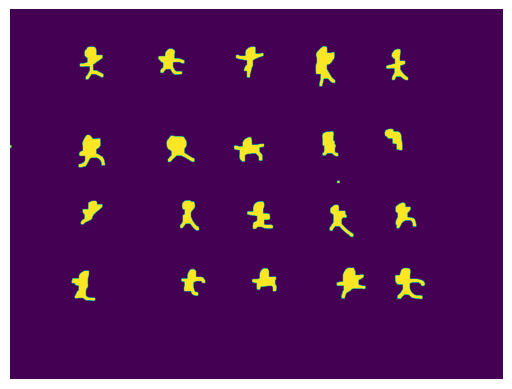

In [65]:
from scripts.image import morphology_closing, morphology_dilatetion

image_canny = cv2.Canny(image_gray, 50, 200)
image_canny_dilated = morphology_closing(image_canny, kernel_size=50)
image_canny_dilated[:50, :] = 0
show_image_from_ndarray(morphology_dilatetion(image_canny_dilated))

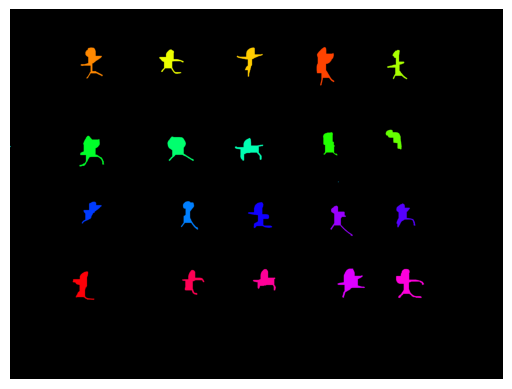

In [66]:
import numpy as np

# CCA-clustering
markers = np.zeros_like(image_canny_dilated)
markers[image_canny_dilated > 0] = 255
markers[image_canny_dilated == 0] = 0
markers = cv2.connectedComponents(image_canny_dilated)[1]

# Draw results
label_hue = np.uint8(179*markers/np.max(markers))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
labeled_img[markers==0] = 0


show_image_from_ndarray(labeled_img)

In [67]:
n_labels = len(np.unique(markers))

mask_list_cluster = []
for l in range(n_labels):
    if l == 0:
        continue
    mask_cluster = np.zeros_like(image_canny)
    mask_cluster[np.where(markers == l)] = 255
    if cv2.countNonZero(mask_cluster) > 5000:
        mask_list_cluster.append(mask_cluster)

print(len(mask_list_cluster))

20


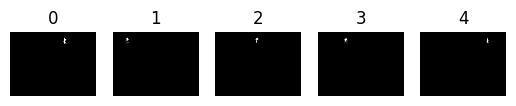

In [68]:
from scripts.image import draw_multiple_image
from scripts.image import gray2bgr

draw_multiple_image([str(idx) for idx in range(len(mask_list_cluster[:5]))], [gray2bgr(mask) for mask in mask_list_cluster[:5]])

In [71]:
from typing import NamedTuple


class MaskProperty(NamedTuple):
    centroid_x: int
    centroid_y: int
    width: int
    height: int


def get_mask_properties_from_binary_mask(mask):
    coordinates = cv2.findNonZero(mask)
    moments = cv2.moments(coordinates)
    centroid_x = int(moments["m10"] / moments["m00"])
    centroid_y = int(moments["m01"] / moments["m00"])
    width = np.max(coordinates[:, 0, 0]) - np.min(coordinates[:, 0, 0])
    height = np.max(coordinates[:, 0, 1]) - np.min(coordinates[:, 0, 1])
    return MaskProperty(centroid_x, centroid_y, width, height)


mask_properties_list = [get_mask_properties_from_binary_mask(mask) for mask in mask_list_cluster]

print(np.mean([mask_property.width for mask_property in mask_properties_list]))
print(np.mean([mask_property.height for mask_property in mask_properties_list]))


180.9
218.35


# Get Clipped Images

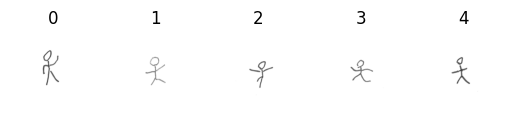

In [112]:
from scripts.ght import Otsu_equivalent

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))

image_list_gray_clipped = []
for mask_property in mask_properties_list:
    sx = mask_property.centroid_x - IMAGE_WIDTH_CLIPPING
    sy = mask_property.centroid_y - IMAGE_WIDTH_CLIPPING
    ex = mask_property.centroid_x + IMAGE_WIDTH_CLIPPING
    ey = mask_property.centroid_y + IMAGE_WIDTH_CLIPPING
    image_gray_clipped = cv2.resize(image_gray[sy:ey, sx:ex].copy(), (IMAGE_WIDTH_OUTPUT, IMAGE_WIDTH_OUTPUT))
    # image_gray_processed = clahe.apply(image_gray_clipped)
    image_gray_processed = np.zeros_like(image_gray_clipped).astype(np.uint8)

    intensities = image_gray_clipped.flatten().astype(float)
    th = intensities[int(Otsu_equivalent(intensities)[0])]

    image_gray_processed = image_gray_clipped.copy()
    image_gray_processed[image_gray_clipped > th * 0.9] = 255

    sxm = int(IMAGE_WIDTH_OUTPUT / 2 - mask_property.width/2 * 1.5)
    sym = int(IMAGE_WIDTH_OUTPUT / 2 - mask_property.height/2 * 1.5)
    exm = int(IMAGE_WIDTH_OUTPUT / 2 + mask_property.width/2 * 1.5)
    eym = int(IMAGE_WIDTH_OUTPUT / 2 + mask_property.height/2 * 1.5)

    image_gray_processed[:sym, :] = 255
    image_gray_processed[eym:, :] = 255
    image_gray_processed[:, :sxm] = 255
    image_gray_processed[:, exm:] = 255

    image_list_gray_clipped.append(image_gray_processed)

draw_multiple_image([str(l) for l in range(len(mask_properties_list[:5]))], image_list_gray_clipped[:5])


In [114]:
import os

if not Path(OUTPUT_DIR).exists():
    os.mkdir(str(OUTPUT_DIR))

output_dir_pathlib = Path(OUTPUT_DIR)
for i, image_clipped in enumerate(image_list_gray_clipped):
    cv2.imwrite(str(output_dir_pathlib.joinpath(f"{i}.png")), image_clipped)
